In [1]:
using CairoMakie, CSV, DataFrames, wgregseq

Precompiling wgregseq
        Info Given wgregseq was explicitly requested, output will be shown live 
  ✓ wgregseq
  1 dependency successfully precompiled in 9 seconds. 306 already precompiled.
  1 dependency had output during precompilation:
┌ wgregseq
│  [Output was shown above]
└  


In [2]:
promoters = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv").promoter |> unique

119-element Vector{String}:
 "rspAp"
 "araBp"
 "znuCp"
 "xylAp"
 "xylFp"
 "dicCp"
 "relBp"
 "ftsKp2"
 "ftsKp1"
 "lacIp"
 "mhpRp2"
 "mhpRp1"
 "marRp"
 ⋮
 "intE_xisE_ymfH_predicted"
 "ymfM_beeE_jayE_ymfL_ymfR_tfaP_ymfT_ymfN_ycfK_ymfQ_predicted"
 "tfaE_stfE_predicted"
 "icdC_predicted"
 "ybiY_ybiW_predicted"
 "ygeW_predicted"
 "ygeX_predicted"
 "ygeY_predicted"
 "hyuA_predicted"
 "ygfM_xdhD_predicted"
 "ygfS_ygfT_predicted"
 "uacT_predicted"

In [3]:
function Levels(_df)
    df = sort(_df, :start)
    levels = [[1]]
    last_ends = [df[1, :stop]]
    for i in 2:nrow(df)
        level = 1
        inserted = false
        start_site = df[i, :start]
        if ismissing(start_site)
            continue
        end
        while inserted == false
            
            if start_site > last_ends[level]
                push!(levels[level], i)
                last_ends[level] = df[i, :stop]
                inserted = true
            else
                level += 1
            end
            if level > length(levels)
                push!(levels, [i])
                push!(last_ends, df[i, :stop])
                inserted = true
            end
        end
    end
    return levels
end
        

Levels (generic function with 1 method)

In [4]:
get_BS_length(x::AbstractString) = isuppercase.(collect(x)) |> sum
get_BS_length(x::Missing) = 0

df = CSV.read("binding_sites.txt", DataFrame)
println(df.RI_FUNCTION[1:20])
df = df[!, [:PROMOTER_NAME, :CENTER_POSITION, :FINAL_STATE, :RI_SEQUENCE, :RI_FUNCTION]]
rename!(
    df,
    Dict("PROMOTER_NAME" => "name", 
         "CENTER_POSITION" => "position",
         "FINAL_STATE" => "tf", 
         "RI_SEQUENCE" => "binding_site",
         "RI_FUNCTION" => "function"))

insertcols!(df, 5, :bs_length => get_BS_length.(df.binding_site))
insertcols!(df, 5, :start => df.position .- (df.bs_length .- 1) ./ 2)
insertcols!(df, 5, :stop => df.position .+ (df.bs_length .- 1) ./ 2);
df

Union{Missing, String15}[String15("repressor"), String15("repressor"), String15("repressor"), String15("repressor"), String15("repressor"), String15("repressor"), String15("repressor"), String15("repressor"), String15("activator"), String15("repressor"), String15("activator"), String15("activator"), String15("activator"), String15("activator"), String15("activator"), String15("activator"), String15("activator"), String15("repressor"), String15("repressor"), String15("repressor")]


Row,name,position,tf,binding_site,stop,start,bs_length,function
,String31,Float64?,String?,String?,Float64?,Float64?,Int64,String15?
1,galRp,8.5,GalR-D-galactose,cactgaaagaATGTAAGCGTTTACCCactaaggtat,16.0,1.0,16,repressor
2,galRp,8.5,GalS-D-galactose,cactgaaagaATGTAAGCGTTTACCCactaaggtat,16.0,1.0,16,repressor
3,mraZp,-42.0,PdhR,tatgccttgtGACTGGCTTGACAAGCTtttcctcagc,-34.0,-50.0,17,repressor
4,mraZp,-3.0,MraZ,ctcctttcagTGGGAaattgtgggg,-1.0,-5.0,5,repressor
5,mraZp,8.0,MraZ,tgggaaattgTGGGGcaaagtggga,10.0,6.0,5,repressor
6,mraZp,18.0,MraZ,tggggcaaagTGGGAataaggggtg,20.0,16.0,5,repressor
7,sohBp1,19.5,CRP-cyclic-AMP,gcctgttgtaAACTGTGAGCCAAAGCGTTGTTtaaccaaggt,30.0,9.0,22,repressor
8,sohBp2,2.0,CRP-cyclic-AMP,tgcctgttgtAAACTGTGAGCCAAAGCGTTGTttaaccaagg,12.5,-8.5,22,repressor
9,mplp1,-37.5,CRP-cyclic-AMP,caatgttgcgCTCAGGTGAATCGCGCCAGCAAattacggatt,-27.0,-48.0,22,activator


In [22]:
function plot_architecture(_df, prom)
    df = _df[_df.name .== prom, :]
    offset = 5
    if nrow(df) > 0 
        downstream_distance = min(min_missing(df[!, :start]), -115) - offset
        upstream_distance = max(max_missing(df[!, :start]), 44) + offset
        sort!(df, :start)
        if ismissing(downstream_distance)
            downstream_distance = -115 - offset
            upstream_distance = 44 + offset
        end
        level_arr = Levels(df)
    else
        downstream_distance = -115 - offset
        upstream_distance = 44 + offset
        level_arr = []
    end
    # Create canvas
    fig = Figure(scene=(800, 400))
    gc_plot = fig[1, 1] = GridLayout()
    gc_legend = fig[2, 1] = GridLayout()
    ax = Axis(gc_plot[1, 1])
    lines!(ax, [-115, -115], [0, 4], color = :gray, linestyle=:dash)
    lines!(ax, [44, 44], [0, 4], color = :gray, linestyle=:dash)
    
    hidexdecorations!(ax)
    hideydecorations!(ax)
    
    hidespines!(ax)
    
    # empty promoter
    band!(ax, [downstream_distance, upstream_distance], [0, 0], [1, 1], color="#FFEDCE")
    
    # edge of promoter
    lines!(ax, [downstream_distance, upstream_distance], [0, 0], color="black", linewidth=2)
    #lines!(ax, [-115, 44], [1, 1], color="black", linewidth=2)
    
    
    # TSS arrow
    lines!(ax, [0, 0], [1, length(level_arr) + 2], color="#34495e", linewidth=2)
    arrows!(ax, [0], [length(level_arr) + 2], [10], [0], color="#34495e", linewidth=2)
    
    #band!(ax, [-45, -25], [4.8, 4.8], [5.8, 5.8], color="#FFFBCE")
    text!(ax, (downstream_distance + upstream_distance)/2, 5, text=prom, align=(:center, :bottom))
    
    function plot_BS(df, fig, ax)
        labels = []
        
        for (index, row) in enumerate(eachrow(df))
            tf = row[3]
            name = row[1]
            stop = row[5]
            start = row[6]
            func = row[8]
            if ismissing(tf) 
                break
            end
            if ismissing(start)
                b, c = [PolyElement(color = :gray, strokewidth = 0),
                LineElement(color = :gray, linestyle = :dash)]
                # Draw outline
                push!(labels, [b, c])
                continue
            end

            level = filter(x -> index ∈ level_arr[x], collect(1:length(level_arr)))[1]
            if func == "activator"
                color = "#BFD496"
            elseif func == "repressor"
                color = "#D56D55"
            else
                color = "gray"
            end
            #if evidence == "low"
                #linestyle=:dash
            #elseif evidence == "high"
                #inestyle=:solid
            #end
            linestyle=:solid
            # Draw box
            
            b = band!(ax, [start, stop], level .+ [0, 0], level .+ [1, 1], color=(color, 0.4))
            # Draw outline
            c = lines!(ax, [start, start, stop, stop, start], level .+ [0, 1, 1, 0, 0], color=color, linestyle=linestyle, linewidth=2)
            text!(ax, (start + stop) / 2, level + 0.5, text="$index", align=(:center, :center))
            push!(labels, [b, c])
        end
        #[scatter!(ax, [0], [0], markersize=0) for i in 1:nrow(df)]
        if length(labels) != 0
            Legend(gc_legend[1, 1],labels, ["$i - $TF" for (i, TF) in enumerate(df.tf)], labelsize=12, nbanks=length(labels)/5 |> ceil |> Int64, tellwidth=false)
        end
    end
    if nrow(df) > 0
        plot_BS(df, fig, ax)
    end
    
    ylims!(ax, -0.5, 6)
    lines!(ax, [downstream_distance, upstream_distance], [1, 1], color="black", linewidth=2)
    fig
end

for prom in promoters
    save("cartoons/$(prom)_cartoon.pdf", plot_architecture(df, prom))
end


In [20]:
function max_missing(x)
    if (skipmissing(x) |> collect |> length) == 0
        return missing
    else
        return maximum(skipmissing(x))
    end
end

function min_missing(x)
    if (skipmissing(x) |> collect |> length) == 0
        return missing
    else
        return minimum(skipmissing(x))
    end
end

min_missing (generic function with 1 method)

In [19]:
skipmissing([missing]) |> collect

Union{}[]

┌ Warning: thread = 1 warning: only found 1 / 6 columns around data row: 82. Filling remaining columns with `missing`
└ @ CSV ~/.julia/packages/CSV/b8ebJ/src/file.jl:576


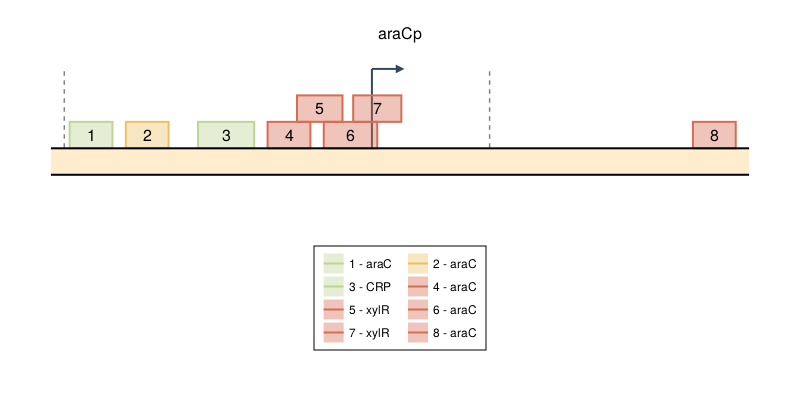

In [141]:
function plot_architecture(_df, prom)
    df = _df[_df.promoter .== prom, :]
    offset = 5
    if nrow(df) > 0
        downstream_distance = min(df[!, :start] |> minimum, -115) - offset
        upstream_distance = max(df[!, :stop] |> maximum, 44) + offset
        sort!(df, :start)
        level_arr = levels(df)
    else
        downstream_distance = -115 - offset
        upstream_distance = 44 + offset
        level_arr = []
    end
    # Create canvas
    fig = Figure(resolution=(800, 400))
    gc_plot = fig[1, 1] = GridLayout()
    gc_legend = fig[2, 1] = GridLayout()
    ax = Axis(gc_plot[1, 1])
    lines!(ax, [-115, -115], [0, 4], color = :gray, linestyle=:dash)
    lines!(ax, [44, 44], [0, 4], color = :gray, linestyle=:dash)
    
    hidexdecorations!(ax)
    hideydecorations!(ax)
    
    hidespines!(ax)
    
    # empty promoter
    band!(ax, [downstream_distance, upstream_distance], [0, 0], [1, 1], color="#FFEDCE")
    
    # edge of promoter
    lines!(ax, [downstream_distance, upstream_distance], [0, 0], color="black", linewidth=2)
    #lines!(ax, [-115, 44], [1, 1], color="black", linewidth=2)
    
    
    # TSS arrow
    lines!(ax, [0, 0], [1, length(level_arr) + 2], color="#34495e", linewidth=2)
    arrows!(ax, [0], [length(level_arr) + 2], [10], [0], color="#34495e", linewidth=2)
    
    #band!(ax, [-45, -25], [4.8, 4.8], [5.8, 5.8], color="#FFFBCE")
    text!(ax, (downstream_distance + upstream_distance)/2, 5, text=prom, align=(:center, :bottom))
    
    function plot_BS(df, fig, ax)
        labels = []
        

        for (index, row) in enumerate(eachrow(df))
            name, start, stop, tf, evidence = row[2:end]
            level = filter(x -> index ∈ level_arr[x], collect(1:length(level_arr)))[1]
            if tf == "act"
                color = "#BFD496"
            elseif tf == "rep"
                color = "#D56D55"
            elseif tf == "dual"
                color = "#EAC264"
            end
            if evidence == "low"
                linestyle=:dash
            elseif evidence == "high"
                linestyle=:solid
            end
            # Draw box
            
            b = band!(ax, [start, stop], level .+ [0, 0], level .+ [1, 1], color=(color, 0.4))
            # Draw outline
            c = lines!(ax, [start, start, stop, stop, start], level .+ [0, 1, 1, 0, 0], color=color, linestyle=linestyle, linewidth=2)
            text!(ax, (start + stop) / 2, level + 0.5, text="$index", align=(:center, :center))
            push!(labels, [b, c])
        end
        #[scatter!(ax, [0], [0], markersize=0) for i in 1:nrow(df)]
        Legend(gc_legend[1, 1],labels, ["$i - $TF" for (i, TF) in enumerate(df.TF)], labelsize=12, nbanks=length(labels)/5 |> ceil |> Int64, tellwidth=false)
    end
    
    if nrow(df) > 0
        plot_BS(df, fig, ax)
    end
    
    ylims!(ax, -0.5, 6)
    lines!(ax, [downstream_distance, upstream_distance], [1, 1], color="black", linewidth=2)
    fig
end

df = CSV.read("binding_sites.txt", DataFrame, delim=" ")
plot_architecture(df, "araCp")

In [ ]:
df = CSV.read("binding_sites.txt", DataFrame, delim=" ")
for prom in ["aceBp", "acrAp", "acrBp", "acrZp", "araBp", "araCp"]
    fig = plot_architecture(df, prom)  
    save("cartoons/$(prom)_ecocyc.pdf", fig)
end

In [ ]:
run(`pwd`)

## Regulon DB table

In [27]:
function levels(_df)
    df = sort(_df, :start)
    levels = [[1]]
    last_ends = [df[1, :stop]]
    for i in 2:nrow(df)
        level = 1
        inserted = false
        start_site = df[i, :start]
        while inserted == false
            if start_site > last_ends[level]
                push!(levels[level], i)
                last_ends[level] = df[i, :stop]
                inserted = true
            else
                level += 1
            end
            if level > length(levels)
                push!(levels, [i])
                push!(last_ends, df[i, :stop])
                inserted = true
            end
        end
    end
    return levels
end
        

ErrorException: error in method definition: function DataAPI.levels must be explicitly imported to be extended

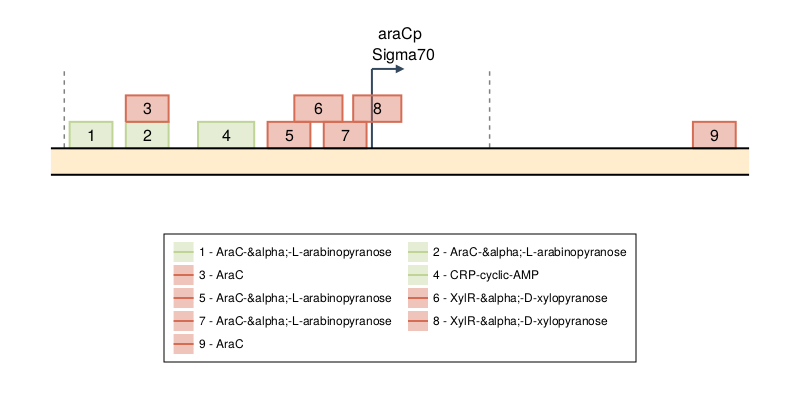

In [148]:
function plot_architecture_2(_df, prom)
    df = _df[_df.PROMOTER_NAME .== prom, :]
    df_annotated = df[.~ ismissing.(df.CENTER_POSITION), :]
    
    BS_length = map(x -> sum(isuppercase.(collect(x))), df_annotated.RI_SEQUENCE)
    insertcols!(df_annotated, 1, :start => Int64.(floor.(((df_annotated[!, :CENTER_POSITION] .- (BS_length .- 1) / 2)))))
    insertcols!(df_annotated, 2, :stop => Int64.(floor.(((df_annotated[!, :CENTER_POSITION] .+ (BS_length .- 1) / 2)))))
    offset = 5
    
    if nrow(df_annotated) > 0
        downstream_distance = min(df_annotated.start |> minimum, -115) - offset
        upstream_distance = max(df_annotated.stop |> maximum, 44) + offset
        sort!(df_annotated, :CENTER_POSITION)
        level_arr = levels(df_annotated)
        SIGMA_FACTOR = df_annotated[!, :SIGMA_FACTOR][1]
    else
        downstream_distance = -115 - offset
        upstream_distance = 44 + offset
        level_arr = []
        SIGMA_FACTOR = "predicted"
    end
    # Create canvas
    fig = Figure(resolution=(800, 400))
    gc_plot = fig[1, 1] = GridLayout()
    gc_legend = fig[2, 1] = GridLayout()
    ax = Axis(gc_plot[1, 1])
    lines!(ax, [-115, -115], [0, 4], color = :gray, linestyle=:dash)
    lines!(ax, [44, 44], [0, 4], color = :gray, linestyle=:dash)
    
    hidexdecorations!(ax)
    hideydecorations!(ax)
    
    hidespines!(ax)
    
    # empty promoter
    band!(ax, [downstream_distance, upstream_distance], [0, 0], [1, 1], color="#FFEDCE")
    
    # edge of promoter
    lines!(ax, [downstream_distance, upstream_distance], [0, 0], color="black", linewidth=2)
    #lines!(ax, [-115, 44], [1, 1], color="black", linewidth=2)
    
    
    # TSS arrow
    lines!(ax, [0, 0], [1, length(level_arr) + 2], color="#34495e", linewidth=2)
    arrows!(ax, [0], [length(level_arr) + 2], [10], [0], color="#34495e", linewidth=2)
    if ~ismissing(SIGMA_FACTOR)
        text!(ax, 0, length(level_arr) + 2.2, text=SIGMA_FACTOR, align=(:left, :bottom))
    end
    
    #band!(ax, [-45, -25], [4.8, 4.8], [5.8, 5.8], color="#FFFBCE")
    text!(ax, (downstream_distance + upstream_distance)/2, 5, text=prom, align=(:center, :bottom))
    function plot_BS(df, fig, ax)
        labels = []
    
        for (index, row) in enumerate(eachrow(df))
            start = row[:start]
            stop = row[:stop]
            level = filter(x -> index ∈ level_arr[x], collect(1:length(level_arr)))[1]
            center = row[:CENTER_POSITION]
            if ismissing(center)
                continue
            end
            tf = row[:RI_FUNCTION]
            if tf == "activator"
                color = "#BFD496"
            elseif tf == "repressor"
                color = "#D56D55"
            elseif tf == "dual"
                color = "#EAC264"
            else 
                println(tf)
            end
                    #=
            if evidence == "low"
                linestyle=:dash
            elseif evidence == "high"
                linestyle=:solid
            end
                    =#
            # Draw box
            linestyle=:solid
    
            b = band!(ax, [start, stop], level .+ [0, 0], level .+ [1, 1], color=(color, 0.4))
            
            # Draw outline
            c = lines!(ax, [start, start, stop, stop, start], level .+ [0, 1, 1, 0, 0], color=color, linestyle=linestyle, linewidth=2)
            text!(ax, (start + stop) / 2, level + 0.5, text="$index", align=(:center, :center))
            push!(labels, [b, c])
        end
        #[scatter!(ax, [0], [0], markersize=0) for i in 1:nrow(df)]
        Legend(gc_legend[1, 1],labels, ["$i - $TF" for (i, TF) in enumerate(df.FINAL_STATE)], labelsize=12, nbanks=length(labels)/5 |> ceil |> Int64, tellwidth=false)
    end
    
    if nrow(df_annotated) > 0
        plot_BS(df_annotated, fig, ax)
    end
    
    ylims!(ax, -0.5, 6)
    lines!(ax, [downstream_distance, upstream_distance], [1, 1], color="black", linewidth=2)
    fig
end



plot_architecture_2(df, "araCp")

In [149]:
df = CSV.read("../../aux_files/binding_sites.txt", DataFrame)

for prom in promoters
    fig = plot_architecture_2(df, prom)
    save("cartoons/$(prom)_DB.pdf", fig)
end

In [150]:
df[df.PROMOTER_NAME .== "rspAp", :]

2×38 DataFrame
 Row │ PROMOTER_ID   PROMOTER_NAME  PROMOTER_STRAND  POS_1    SIGMA_FACTOR  BA ⋯
     │ String15      String31       String7          Int64?   String7?      Mi ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ECK125328140  rspAp          reverse          1655171  missing          ⋯
   2 │ ECK125328140  rspAp          reverse          1655171  missing         
                                                              33 columns omitted